In [817]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import torch.nn as nn
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from typing import List
from typing import Tuple

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#local
dataFolder = os.path.join(os.getcwd(),"Data")
#Kaggle
#dataFolder = "/kaggle/input/titanic"
for dirname, _, filenames in os.walk(dataFolder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
        
RANDOM_SEED = 41
torch.manual_seed(RANDOM_SEED)

c:\Dev\Titanic\Data\submission.csv
c:\Dev\Titanic\Data\test.csv
c:\Dev\Titanic\Data\train.csv


Some Helper Functions

In [818]:
def printUniqueCounts(df, columnName: str = None):
    column = None
    if columnName is None:
        column = df
    else:
        column = df[columnName]
    titles = column.unique()
    counts = []
    for title in titles:
        if pd.isna(title):
            count = sum(column.isnull())
        else:
            count = sum(column==title)
        counts.append([title,count])
    
    counts.sort(key=lambda x: -x[1])
    
    for item in counts:
        print(str(item[0])+": "+str(item[1]))

def torchEnumerator(tensor):
    array = tensor.detach().numpy()
    print("shape" + str(array.shape))
    return np.nditer(array)

In [819]:
trainFilePath = os.path.join(dataFolder,'train.csv')
trainData = pd.read_csv(trainFilePath)
print(trainData.shape)
trainDataRows = trainData.shape[0]
trainData.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We will concat the test data to the training Data, so that all data manipulation happens to both data sets

In [820]:
testFilePath = os.path.join(dataFolder,'test.csv')
testData = pd.read_csv(testFilePath)
testDataRows = testData.shape[0]
trainData = pd.concat([trainData,testData])

Now it's time to clean up the data for use with our ML algorithm and do some feature engineering.

First lets see which columns have NaN / null values:

In [821]:
for column in trainData.columns:
    empty = len(trainData[trainData[column].isnull()])
    if empty>0: print(column + " has " + str(empty) + " missing data points")

Survived has 418 missing data points
Age has 263 missing data points
Fare has 1 missing data points
Cabin has 1014 missing data points
Embarked has 2 missing data points


We will fill in missing age values with average age for now. In the future we may want to infer the age from the other columns, but for now this will have to suffice.

In [822]:
#fill in missing age values with average age
avgAge = trainData["Age"].mean()
print(F"Average age: {avgAge}")
trainData["Age"].fillna(avgAge, inplace=True)

Average age: 29.881137667304014


To gain a better idea of how to handle the missing values in embarked, lets first see how many people embarked from each port:

In [823]:

printUniqueCounts(trainData,"Embarked")

S: 914
C: 270
Q: 123
nan: 2


For the two passengers with unknown ports of embarcation, lets simply fill in the data with the most likely possibility: S

In [824]:
trainData["Embarked"].fillna("S", inplace=True)

There are only 3 ports of embarcation, which makes this feature a good candidate for one-hot encoding. Missing values will simply be recorded as 'False' in all embarcation ports

In [825]:
trainData = pd.get_dummies(trainData,columns=["Embarked"])
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,False,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,True,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,False,True
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,False,False,True
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,False,False,True


The remaining column with missing data is Cabin. This is really two features: cabin area (the letter) and cabin number (the integer). For the sake of simplicity, lets assume the cabin number is not useful, but that the cabin area is. This is a reasonable assumption because the cabin area is likely to have a large effect on the location of the passenger, whereas the cabin number is less likely to have a large effect.

In [826]:

def getCabinLetter(cabin: str):
    if cabin is None or not isinstance(cabin,str): return None
    result =  re.search("^[a-zA-Z]*",cabin)
    if not result: return None
    return result[0]
    
cabinLetter = trainData["Cabin"].apply(getCabinLetter)

print("Cabin Letters")
printUniqueCounts(cabinLetter)


Cabin Letters
None: 1014
C: 94
B: 65
D: 46
E: 41
A: 22
F: 21
G: 5
T: 1


We can see there are only 8 valid options for cabin letter. Being a small number this is a good candidate for one-hot encoding, again solving the missing data issue.

In [827]:
trainData["Cabin"] = cabinLetter
trainData = pd.get_dummies(trainData,columns=["Cabin"])
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,False,True,False,False,False,False,False,False,False,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,False,False,False,True,False,False,False,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,False,True,False,False,False,False,False,False,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,False,True,False,False,True,False,False,False,False,False
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,False,True,False,False,False,False,False,False,False,False


That covers all the missing data, so now we just need to deal with non-numeric data. Lets start by converting Male/Female and True/False to 0/1

In [828]:
trainData["Sex"] = trainData["Sex"]=="male"
trainData = trainData*1
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,0,0,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,1,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,0,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,0,1,0,0,1,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,0,0,0,0


Name and Ticket remain as non-numeric data. We probably could do some NLP to make useful inferences out of the names, but that would be a lot of work and likely not yield a big difference in results. Ticket is also likely not to be very useful info. So lets just delete both columns.

In [829]:
trainData = trainData.drop(columns=["Name","Ticket","PassengerId"])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0
1,1.0,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0
2,1.0,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0
3,1.0,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0
4,0.0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0


In [830]:
printUniqueCounts(trainData,"Survived")

0.0: 549
nan: 418
1.0: 342


Now lets do a little bit of feature engineering. Most of these features look pretty useful as is, but Sibsp and Parch stand out as being a potentially useful target for a little bit of engineering. 
SibSp: siblings and spouses
Parch: parents and children

We can combine these two to get family size. Total family size might be an important metric so lets make an additional column for family size 

In [831]:

trainData.insert(len(trainData.columns),"FamSize",trainData["SibSp"]+trainData["Parch"])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,0.0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0,1
2,1.0,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0,1
4,0.0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,0


To complete our feature engineering we will to normalize the data. Lets use zscore normalization on Age and Fare:

In [832]:
colsToNormalize = ["Age","Fare"]
scalers = {}
for col in colsToNormalize:
    scaler = StandardScaler()
    scalers[col] = scaler
    colData = trainData[col].values.reshape(-1,1)
    scaler.fit(colData)
    trainData[col] = scaler.transform(colData)
trainData.head()




,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,0.0,3,1,-0.611972,1,0,-0.503402,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,0,0.630431,1,0,0.734222,1,0,0,0,0,1,0,0,0,0,0,1
2,1.0,3,0,-0.301371,0,0,-0.490356,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,1,0,0.397481,1,0,0.382778,0,0,1,0,0,1,0,0,0,0,0,1
4,0.0,3,1,0.397481,0,0,-0.487940,0,0,1,0,0,0,0,0,0,0,0,0


Recall how we appended the test data to the training data in order to manipulate both sets simultaneously. Lets now undo that.

In [833]:
testData = trainData.tail(testDataRows)
trainData = trainData.head(trainDataRows)
testData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,NaN,3,1,0.358655,0,0,-0.492208,0,1,0,0,0,0,0,0,0,0,0,0
1,NaN,3,0,1.329283,1,0,-0.508234,0,0,1,0,0,0,0,0,0,0,0,1
2,NaN,2,1,2.494035,0,0,-0.456291,0,1,0,0,0,0,0,0,0,0,0,0
3,NaN,3,1,-0.223721,0,0,-0.476102,0,0,1,0,0,0,0,0,0,0,0,0
4,NaN,3,0,-0.611972,1,1,-0.406039,0,0,1,0,0,0,0,0,0,0,0,2


Some Helpers for later

In [834]:
def getPrediction(yHat:np.array):
    if isinstance(yHat,torch.Tensor):
        yHat = ToNumpy(yHat) 
    return (yHat>0.5).astype(int)    

def SeparateData(dataFrame:pd.DataFrame)->Tuple[np.ndarray,np.ndarray]:
    yColName = "Survived"
    if yColName not in dataFrame.columns:
        Y = None
    else:
        Y= dataFrame[yColName]
    X = dataFrame.drop(columns=yColName)
    return (X.values,Y.values)

def GetFeatureCount(X:np.ndarray):return X.shape[1]

def ToTensor(arr:np.ndarray)->torch.Tensor:
    tens = torch.tensor(arr, dtype=torch.float32)
    if len(arr.shape)==1:
        tens.unsqueeze_(1)
    return tens

def ToNumpy(tens:torch.tensor)->np.ndarray:
    if tens is np.ndarray: return tens
    if torch.cuda.is_available():
        tens = tens.cpu()
    while tens.shape[-1] == 1:
        tens = tens.squeeze(1)
    return tens.detach().numpy()

Now lets write a class for the learners

In [835]:
class Layer(nn.Module):
    def __init__(self, nodeCount: int, activation_function: nn.Module):
        super().__init__()
        self.nodeCount = nodeCount
        self.activation_function = activation_function

    def setInputCount(self,inputCount:int):
        self.linear = nn.Linear(inputCount,self.nodeCount)
    
    def forward(self,x:torch.Tensor): 
        output = self.linear(x)
        activationFunction = self.activation_function
        if activationFunction is not None:
            output = activationFunction(output)
        return output

    def set_to_cuda(self):
        self.linear = self.linear.cuda()
        if self.activation_function is not None: self.activation_function = self.activation_function.cuda()

class Learner(nn.Module):
    def __init__(self, input_feature_count:int, layers: nn.ModuleList):
        super().__init__()
        self.input_feature_count = input_feature_count
        lastNodeCount = input_feature_count
        for layer in layers:
            layer.setInputCount(lastNodeCount)
            lastNodeCount = layer.nodeCount

        self.layers = layers
            

    def forward(self,x:torch.Tensor):
        for l in self.layers: x = l.forward(x)
        return x
    
    def set_to_cuda(self):
        for layer in self.layers:
            layer.set_to_cuda()


def buildLayers(hiddenLayers=[]):
    layers = nn.ModuleList()
    for i in hiddenLayers: layers.append(Layer(i,nn.ReLU()))
    return layers

def buildLayersBinaryClassification(hiddenLayers=[],outputCount=1):
    layers = buildLayers(hiddenLayers)
    layers.append(Layer(outputCount,nn.Sigmoid()))
    return layers


class TrainingParameters:
    def __init__(self):
        self.learningRate = 1e-2
        self.regularization_constant = 1e-2
        self.iterations = 100
        self.lossFunction = torch.nn.BCELoss()

class TrainingResult:
    def __init__(self):
        self.training_result = SubsetResult()
        self.validation_result = SubsetResult()
    def all(self):return [self.training_result,self.validation_result]

class SubsetResult():
    def __init__(self):
        self.f1_score = []
        self.accuracy = []
        self.loss = []
    

class Dataset():

    def __init__(self,XTrain,yTrain,XVal,yVal):
        def assertRows(x,y):
            if x.shape[0] != y.shape[0]:
                raise ValueError("Row count mismatch between input and target")
        assertRows(XTrain,yTrain)
        assertRows(XVal,yVal)
        self.XTrain = XTrain
        self.yTrain = yTrain
        self.XVal = XVal
        self.yVal = yVal
        
    def to_tensor_(self):
        self.XTrain = ToTensor(self.XTrain)
        self.yTrain = ToTensor(self.yTrain)
        self.XVal = ToTensor(self.XVal)
        self.yVal = ToTensor(self.yVal)
    
    def training_subset(self,booleanIndices):
        return Dataset(self.XTrain[booleanIndices],self.yTrain[booleanIndices],self.XVal,self.yVal)
    
    def all(self): return [self.XTrain,self.yTrain,self.XVal,self.yVal]

    @property
    def rows(self): return self.XTrain.shape[0]

    def is_tensor(self): all(isinstance(x, torch.Tensor) for x in self.all() )

class TrainingSequence:
    def __init__(self,model:nn.Module,params:TrainingParameters):
        self.model = model
        self.params = params
    
    def fit(self,data:Dataset)->TrainingResult:
        if not data.is_tensor(): data.to_tensor_()

        model = self.model
        params = self.params
        optimizer = torch.optim.Adam(params=model.parameters(),lr=params.learningRate,weight_decay=params.regularization_constant)
        lossFn = params.lossFunction
        result = TrainingResult()
        trainResult = result.training_result
        valResult = result.validation_result

        def evaluate(X,y,resultObj,train=False):
            #forward prop and loss
            yHat = model.forward(X)
            l = lossFn(yHat,y)

            #results for analysis
            y = ToNumpy(y)
            yHat = ToNumpy(yHat)
            prediction = self.predictFromYHat(yHat)
            f1 = f1_score(prediction,y,average="micro")
            acc= accuracy_score(prediction,y)
            resultObj.loss.append(l.item())
            resultObj.f1_score.append(f1)
            resultObj.accuracy.append(acc)

            if train:#dont train on the validation set
                 #actual training  happens here
                l.backward()
                optimizer.step()
                optimizer.zero_grad()

        for _ in range(params.iterations):
            evaluate(data.XTrain,data.yTrain,trainResult,train=True)
            evaluate(data.XVal,data.yVal,valResult,train=False)
        return result

    def predictFromYHat(self,yHat):
        prediction = getPrediction(yHat)
        return prediction
    
    def predict(self,X)->np.ndarray:
        if isinstance(X, np.ndarray):
            X = ToTensor(X)
        yHat = ToNumpy(self.model.forward(X))    
        return self.predictFromYHat(yHat)

And a function to train the boosted model

In [836]:
class BoostedTrainingResult:
    def __init__(self):
        self.learnerResults = []
        self.classifierResult = TrainingResult
        self.metaModelResult = TrainingResult

class BoostedModel:
    def __init__(self,learners:List[TrainingSequence],classifier:TrainingSequence, metaModel:TrainingSequence):
        self.learners = learners
        self.classifier = classifier
        self.metaModel = metaModel


    def fit(self,data:Dataset)->BoostedTrainingResult:
        learners = self.learners
        
        rows = data.rows
        learnerCount = len(learners)

        #classifications stores which model was trained on which data points
        classifications = np.zeros((rows,learnerCount))
        #first model trains on all data
        currentRows = np.full((rows,),True, dtype=bool)

        result = BoostedTrainingResult()
        for (i,sequence) in enumerate(learners):
            classifications[:,i] = currentRows.astype(int)
            subset = data.training_subset(currentRows)
            print(F"subset size: {subset.rows}")
            learnerResult = sequence.fit(subset)
            result.learnerResults.append(learnerResult)
            prediction = sequence.predict(data.XTrain)
            currentRows = prediction!=data.yTrain
        print("Classifications:")
        print(classifications)
        (xClassTrain,xClassVal,yClassTrain,yClassVal) = train_test_split(data.XTrain,classifications,test_size=.2)
        classificationData = Dataset(xClassTrain,yClassTrain,xClassVal,yClassVal)



        #train classifier
        classifierSequence = self.classifier
        result.classifierResult = classifierSequence.fit(classificationData)


        #train meta model
        learnerPredictions = np.zeros(rows,le)
        for 
        return result



Some Functions for plotting

In [837]:
def PlotResult(result:TrainingResult,title):
    trainingResult = result.training_result
    validationResult = result.validation_result

    iterations = len(trainingResult.loss)
    epochs = range(0,iterations)
    fig = plt.figure()
    fig.suptitle(title)
    ax1 = plt.gca()
    ax1.plot(epochs,trainingResult.loss,color="#f50707",label="training loss")
    ax1.plot(epochs,validationResult.loss, color="#f507ed",label="validation loss")
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.plot(epochs,trainingResult.accuracy,color="#05f545",label = "training accuracy")
    ax2.plot(epochs,validationResult.accuracy,color="#086e21",label = "validation accuracy")
    ax2.plot(epochs,trainingResult.f1_score,color="#081c6e",label="training f1")
    ax2.plot(epochs,validationResult.f1_score,color="#02c9cc",label="validation f1")
    ax2.legend()

    valf1 = validationResult.f1_score
    maxEpoch = np.argmax(valf1)


    print(f"Peak cross validation f1: {valf1[maxEpoch]} at epoch {maxEpoch} with accuracy {validationResult.accuracy[maxEpoch]}. Training Acc {trainingResult.accuracy[maxEpoch]}")

Let's take it for a spin!

training classifier...
subset size: 712
subset size: 115


Classifications:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
predicted classifications:
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
Peak cross validation f1: 0.8659217877094972 at epoch 160 with accuracy 0.8659217877094972. Training Acc 0.8328651685393258
Peak cross validation f1: 0.4134078212290503 at epoch 0 with accuracy 0.4134078212290503. Training Acc 0.7043478260869566
Peak cross validation f1: 0.9438943894389439 at epoch 1 with accuracy 0.8811188811188811. Training Acc 0.029876977152899824


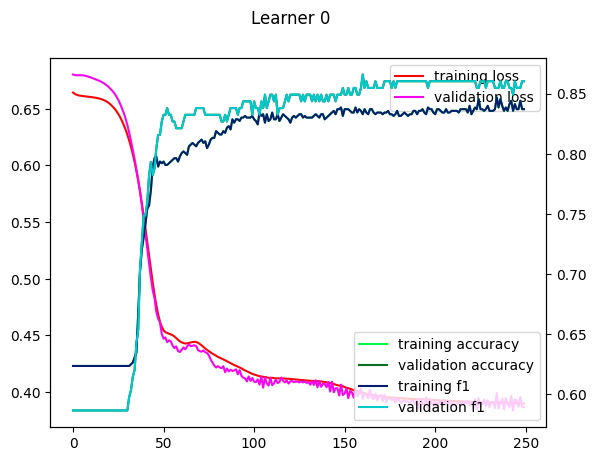

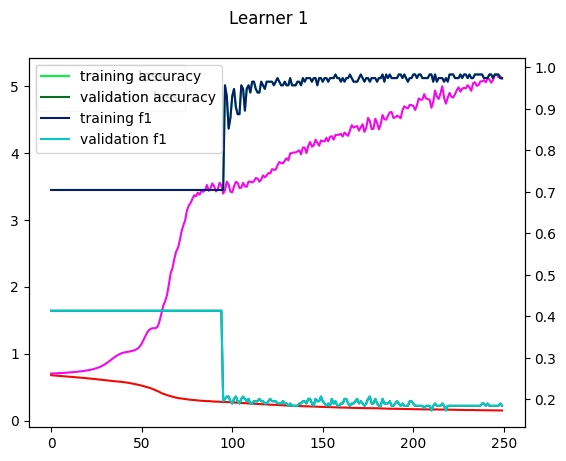

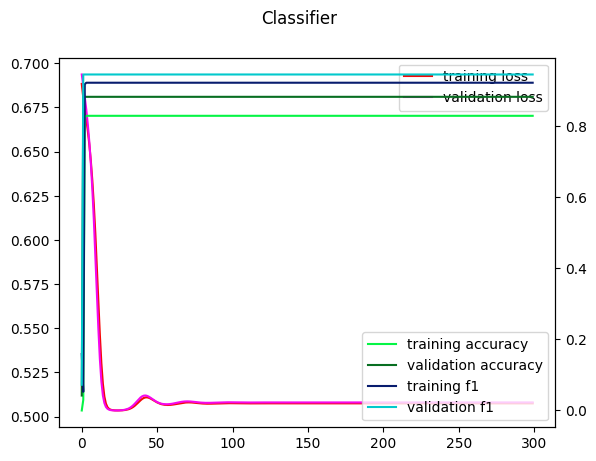

In [838]:
(X,y) = SeparateData(trainData)
(XTrain,XVal,yTrain,yVal) = train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)
data = Dataset(XTrain,yTrain,XVal,yVal)


#build learners
learningRate = 1e-2
regularizationConstant = 1e-2
iterations = 250
hiddenLayers = [10,5,2]
learnerCount = 2
learners = []
featureCount = GetFeatureCount(X)
for _ in range(learnerCount):
    layers = buildLayersBinaryClassification(hiddenLayers)
    learner = Learner(featureCount,layers)
    params = TrainingParameters()
    params.learningRate = learningRate
    params.regularization_constant = regularizationConstant
    params.iterations = iterations
    params.lossFunction = torch.nn.BCELoss()

    learners.append(TrainingSequence(learner,params))



#build classifier
hiddenLayers = [50,20,10]
layers = buildLayersBinaryClassification(hiddenLayers,learnerCount)
classifier = Learner(featureCount,layers)
params = TrainingParameters()
params.learningRate = learningRate
params.regularization_constant = regularizationConstant
params.iterations = 100
params.lossFunction = torch.nn.BCEWithLogitsLoss()
classifierSequence = TrainingSequence(classifier,params)


#build meta model
hiddenLayers = [50,20,10]
layers = buildLayersBinaryClassification(hiddenLayers)
metaModel = Learner(learnerCount*2,layers)
params = TrainingParameters()
params.learningRate = learningRate
params.regularization_constant = regularizationConstant
params.iterations = 100
params.lossFunction = torch.nn.BCEWithLogitsLoss()
metaModelSequence = TrainingSequence()



model = BoostedModel(learners,classifierSequence,metaModel)
completeResult = model.fit(data)







# plot the results
for (i,learnerResult) in enumerate(completeResult.learnerResults):
    PlotResult(learnerResult,F"Learner {i}")

PlotResult(completeResult.classifierResult,"Classifier")

